# Libraries

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

#Visuializations
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px

#Missing Values
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp

#Outliers
from sklearn.neighbors import LocalOutlierFactor

#Multicolinealidad
from varclushi import VarClusHi

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Dimensional Scaling
from sklearn.decomposition import PCA

#Clustering
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import linkage,cophenet,dendrogram
from scipy.spatial.distance import pdist

#Miscelaneous
from collections import Counter

#Settings
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
%matplotlib inline
style.use("ggplot")
plt.rcParams["figure.figsize"] = (8,6)

In [2]:
pd.set_option('display.max_columns',1000)

# Functions

In [3]:
# Frequencies
def freq(df, var):
    if type(var) != list:
        var = [var]
    
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f"Frequencies table for variable {v} \n")    
        print(aux,"\n")

In [4]:
#Normalize
def normalize(df, v, umbral):
    #
    aux = df[v].value_counts(True).to_frame()
    aux[f'v_{v}'] = np.where( aux[v] < umbral , 'SMALL_CATEGORIES', aux.index   )
    moda = aux.head(1)[f'v_{v}'].values[0]
    if aux.loc[aux[f'v_{v}'] == 'SMALL_CATEGORIES'][v].sum() < umbral: 
        aux[f'v_{v}'].replace({'SMALL_CATEGORIES':moda},inplace=True)

    aux.drop(v,axis=1, inplace=True)
    aux.reset_index(inplace=True)

    return df.merge(aux, left_on=[v], right_on='index',how='inner').drop('index',axis=1)

In [5]:
def score_silhouette(X,min_compo,max_compo):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(min_compo,max_compo), metric = "silhouette").fit(X)
    return visualizer.show()

In [6]:
def elbow(X,min_compo,max_compo):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(min_compo,max_compo)).fit(X)
    return visualizer.show()

In [7]:
def score_calinski(X,min_compo,max_compo):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(min_compo,max_compo), metric="calinski_harabasz").fit(X)
    return visualizer.show()

In [8]:
def var_rename(df, v):
    
    df[f'c_{v}'] = df[v].copy()
    df.drop(columns=v, inplace =True)
    
    return df

# Data

## Data Loading

In [9]:
df = pd.read_csv("./Portland/portland_housing.csv")
df.head()

/tmp/ipykernel_34808/3545650672.py:1: DtypeWarning: Columns (20,50,161,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Portland/portland_housing.csv")


abbreviatedAddress address/city  address/zipcode  bathrooms  bedrooms  \
0  2860 NE Blossom Hill Rd     Fairview            97024        3.0       3.0   
1    20386 NE Mackenzie Ln     Fairview            97024        3.0       3.0   
2          1121 SW 10th Dr      Gresham            97080        3.0       4.0   
3       19309 NE Glisan St     Portland            97230        1.0       3.0   
4         25-65 NW 20th St      Gresham            97030        3.0       6.0   

                         brokerageName      dateSold  daysOnZillow  \
0                                  NaN  1.621560e+12          25.0   
1  Harcourts Real Estate Network Group  1.619140e+12          53.0   
2             ERA Freeman & Associates  1.622760e+12          11.0   
3         Premiere Property Group, LLC  1.622760e+12          11.0   
4                                  NaN  1.622510e+12          14.0   

                                         description  favoriteCount  \
0  2860 NE Blossom Hill Rd, Fairview, OR 97024 is...            NaN   
1  Cute as a button 3bed/2.5bath home with brand ...            NaN   
2  What a wonderful large home at end of quiet cu...            NaN   
3                                                NaN            1.0   
4  25-65 NW 20th St, Gresham, OR 97030 is a apart...            NaN   

      homeStatus       homeType  lastSoldPrice   latitude  livingArea  \
0  RECENTLY_SOLD      TOWNHOUSE         315400  45.543571      1806.0   
1  RECENTLY_SOLD  SINGLE_FAMILY         400000  45.547585      1518.0   
2  RECENTLY_SOLD  SINGLE_FAMILY         512000  45.488228      2724.0   
3  RECENTLY_SOLD  SINGLE_FAMILY         348000  45.526634      1217.0   
4  RECENTLY_SOLD      APARTMENT         510000  45.511238      2400.0   

    longitude  lotSize  pageViewCount postingContact/name   price  \
0 -122.441765   1555.0           47.0                 NaN  315400   
1 -122.453224   3484.0            4.0        Julie Murray  400000   
2 -122.444420   9583.0          153.0      Michelle Haage  512000   
3 -122.464088  13939.0           32.0       Greg Whistler  348000   
4 -122.431534   8545.0            2.0                 NaN  510000   

  priceHistory/0/attributeSource/infoString1  \
0                                        NaN   
1                                 21608411.0   
2                                 21556588.0   
3                                 21339669.0   
4                                        NaN   

  priceHistory/0/attributeSource/infoString2  \
0                              Public Record   
1                                  RMLS (OR)   
2                                  RMLS (OR)   
3                                  RMLS (OR)   
4                              Public Record   

          priceHistory/0/attributeSource/infoString3  \
0                                                NaN   
1  https://photos.zillowstatic.com/fp/ca2b2c15d6e...   
2  https://photos.zillowstatic.com/fp/ca2b2c15d6e...   
3  https://photos.zillowstatic.com/fp/ca2b2c15d6e...   
4                                                NaN   

  priceHistory/0/buyerAgent/name  \
0                            NaN   
1                   David Girard   
2                            NaN   
3                            NaN   
4                            NaN   

                 priceHistory/0/buyerAgent/photo/url  \
0                                                NaN   
1  https://photos.zillowstatic.com/h_e/ISvkz56dm7...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  priceHistory/0/buyerAgent/profileUrl priceHistory/0/date  \
0                                  NaN           5/21/2021   
1          /profile/Portland-Realtor1/           4/23/2021   
2                                  NaN            6/4/2021   
3                                  NaN            6/4/2021   
4                                  NaN  

## Cleaning / pre-treatment

In [10]:
df.shape, df["zpid"].nunique()

((25731, 348), 25692)

### Drop duplicated listings

In [11]:
df.shape[0] - df["zpid"].nunique()

39

In [12]:
#zpID is the property ID on Zillow, so we're using it as part of our um variable
#It has 39 properties repeated, we will drop the repeated properties

In [13]:
df = df.drop_duplicates(subset=["zpid"])

### Missings

In [14]:
miss = pd.DataFrame((1 - df.isnull().sum()/df.shape[0])*100).rename(columns={0: "Completed"})
miss

Completed
abbreviatedAddress                           100.000000
address/city                                 100.000000
address/zipcode                              100.000000
bathrooms                                     98.116145
bedrooms                                      97.002958
brokerageName                                 83.049198
dateSold                                     100.000000
daysOnZillow                                  99.976646
description                                   99.540713
favoriteCount                                 38.229799
homeStatus                                   100.000000
homeType                                     100.000000
lastSoldPrice                                100.000000
latitude                                      99.953293
livingArea                                    98.190098
longitude                                     99.953293
lotSize                                       88.774716
pageViewCount                                 56.204266
postingContact/name                           82.679433
price                                        100.000000
priceHistory/0/attributeSource/infoString1    81.947688
priceHistory/0/attributeSource/infoString2    98.999689
priceHistory/0/attributeSource/infoString3    81.823136
priceHistory/0/buyerAgent/name                37.050444
priceHistory/0/buyerAgent/photo/url           36.953137
priceHistory/0/buyerAgent/profileUrl          37.050444
priceHistory/0/date                          100.000000
priceHistory/0/event                         100.000000
priceHistory/0/postingIsRental               100.000000
priceHistory/0/price                         100.000000
priceHistory/0/priceChangeRate               100.000000
priceHistory/0/pricePerSquareFoot             97.999377
priceHistory/0/sellerAgent/name               70.364316
priceHistory/0/sellerAgent/photo/url          66.950802
priceHistory/0/sellerAgent/profileUrl         70.364316
priceHistory/0/showCountyLink                100.000000
priceHistory/0/source                        100.000000
priceHistory/0/time                          100.000000
priceHistory/1/attributeSource/infoString1    36.443251
priceHistory/1/attributeSource/infoString2    93.815195
priceHistory/1/attributeSource/infoString3    39.907364
priceHistory/1/date                           94.519695
priceHistory/1/event                          94.519695
priceHistory/1/postingIsRental                94.519695
priceHistory/1/price                          94.484664
priceHistory/1/priceChangeRate                94.519695
priceHistory/1/pricePerSquareFoot             93.172972
priceHistory/1/showCountyLink                 94.519695
priceHistory/1/source                         94.519695
priceHistory/1/time                           94.519695
priceHistory/2/attributeSource/infoString1    33.477347
priceHistory/2/attributeSource/infoString2    91.086720
priceHistory/2/attributeSource/infoString3    37.564222
priceHistory/2/date                           91.289117
priceHistory/2/event                          91.289117
priceHistory/2/postingIsRental                91.289117
priceHistory/2/price                          91.254087
priceHistory/2/priceChangeRate                91.289117
priceHistory/2/pricePerSquareFoot             90.242099
priceHistory/2/showCountyLink                 91.289117
priceHistory/2/source                         91.289117
priceHistory/2/time                           91.289117
priceHistory/3/attributeSource/infoString2    77.817998
priceHistory/3/date                           79.472209
priceHistory/3/event                          79.472209
priceHistory/3/postingIsRental                79.472209
priceHistory/3/price                          79.409933
priceHistory/3/priceChangeRate                79.472209
priceHistory/3/pricePerSquareFoot             76.852717
priceHistory/3/showCountyLink                 79.472209
priceHistory/3/source                         79.472209
priceHistory/3

In [15]:
#We drop columns where we have 30%+ missing values
df.drop(columns=list(miss[miss["Completed"]<70].index), inplace = True)

### Dropping Unnecessary Columns 

In [16]:
#We have over 100 columns, most of which are not necessary
#We will obtain the unique "categories" of the variables and then decide which ones to drop
cols = df.columns.astype(str).tolist()
cols_split = [l.split("/")[0] for l in cols]
print(len(cols_split))
cols_split

177


['abbreviatedAddress',
 'address',
 'address',
 'bathrooms',
 'bedrooms',
 'brokerageName',
 'dateSold',
 'daysOnZillow',
 'description',
 'homeStatus',
 'homeType',
 'lastSoldPrice',
 'latitude',
 'livingArea',
 'longitude',
 'lotSize',
 'postingContact',
 'price',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 'priceHistory',
 '

In [17]:
unique_cols = list(set(cols_split))
unique_cols

['abbreviatedAddress',
 'address',
 'homeStatus',
 'zestimateHighPercent',
 'livingArea',
 'zpid',
 'homeType',
 'taxAssessedYear',
 'schools',
 'price',
 'solarPotential',
 'propertyTaxRate',
 'latitude',
 'postingContact',
 'taxHistory',
 'daysOnZillow',
 'taxAssessedValue',
 'zestimateLowPercent',
 'brokerageName',
 'url',
 'zestimate',
 'bathrooms',
 'yearBuilt',
 'lotSize',
 'resoFacts',
 'rentZestimate',
 'longitude',
 'bedrooms',
 'dateSold',
 'lastSoldPrice',
 'priceHistory',
 'description',
 'rentalApplicationsAcceptedType',
 'restimateLowPercent',
 'restimateHighPercent']

In [18]:
# We will delete every column starting with the following characters
delete_col = ["url", "description", "priceHistory", "resoFacts", "schools", "taxHistory"]
cols_new = [c for c in unique_cols if c not in delete_col]
cols_new

['abbreviatedAddress',
 'address',
 'homeStatus',
 'zestimateHighPercent',
 'livingArea',
 'zpid',
 'homeType',
 'taxAssessedYear',
 'price',
 'solarPotential',
 'propertyTaxRate',
 'latitude',
 'postingContact',
 'daysOnZillow',
 'taxAssessedValue',
 'zestimateLowPercent',
 'brokerageName',
 'zestimate',
 'bathrooms',
 'yearBuilt',
 'lotSize',
 'rentZestimate',
 'longitude',
 'bedrooms',
 'dateSold',
 'lastSoldPrice',
 'rentalApplicationsAcceptedType',
 'restimateLowPercent',
 'restimateHighPercent']

In [19]:
#We obtain the complete name of the columns we're leaving in the dataset
cols = [c for c in cols if c.split("/")[0] in cols_new]
print(len(cols))
cols

34


['abbreviatedAddress',
 'address/city',
 'address/zipcode',
 'bathrooms',
 'bedrooms',
 'brokerageName',
 'dateSold',
 'daysOnZillow',
 'homeStatus',
 'homeType',
 'lastSoldPrice',
 'latitude',
 'livingArea',
 'longitude',
 'lotSize',
 'postingContact/name',
 'price',
 'propertyTaxRate',
 'rentZestimate',
 'rentalApplicationsAcceptedType',
 'restimateHighPercent',
 'restimateLowPercent',
 'solarPotential/buildFactor',
 'solarPotential/climateFactor',
 'solarPotential/electricityFactor',
 'solarPotential/solarFactor',
 'solarPotential/sunScore',
 'taxAssessedValue',
 'taxAssessedYear',
 'yearBuilt',
 'zestimate',
 'zestimateHighPercent',
 'zestimateLowPercent',
 'zpid']

In [20]:
#We filter the columns and the replace the /'s for _
#Then, we see which other columns are innecessary
df = df[cols]

df.columns = [c.replace('/','_') for c in df.columns.tolist()]

df.drop(columns=["abbreviatedAddress", "dateSold", "postingContact_name", "zestimate"], axis=1, inplace = True)

In [21]:
df.shape

(25692, 30)

In [22]:
#99.5% of the price difference between current price and last sold price is 0, we're dropping current price column
(df["price"] - df["lastSoldPrice"]).value_counts(True)

 0          0.995563
 44900      0.000078
 44500      0.000078
 30500      0.000078
 105000     0.000078
 45000      0.000078
 43400      0.000039
 145014     0.000039
 37000      0.000039
 25700      0.000039
 32600      0.000039
-248205     0.000039
 20100      0.000039
 48300      0.000039
 32467      0.000039
 1339000    0.000039
 2181000    0.000039
 65000      0.000039
-880600     0.000039
 299000     0.000039
 15000      0.000039
 16600      0.000039
 49900      0.000039
-1169250    0.000039
 2048000    0.000039
 1750000    0.000039
 33500      0.000039
 41000      0.000039
 75000      0.000039
 128000     0.000039
-631350     0.000039
 26100      0.000039
 36400      0.000039
-283205     0.000039
-437200     0.000039
 117500     0.000039
 32900      0.000039
 74900      0.000039
-387705     0.000039
 30900      0.000039
 29900      0.000039
-622905     0.000039
 46500      0.000039
 38700      0.000039
 42600      0.000039
 22600      0.000039
-452505     0.000039
-447400     0

In [23]:
df.drop(columns=["price", "latitude", "longitude"], axis=1, inplace=True)

### Variable creation

In [24]:
#Bathroom - Bedroom relation
df["p_bathrooms"] = pd.DataFrame(df["bathrooms"]/df["bedrooms"])
df["p_bathrooms"].replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
#lastSoldPrice - lotSize Relation

df["p_lastPrice"] = pd.DataFrame(df["lastSoldPrice"]/df["lotSize"])
df["p_lastPrice"].replace([np.inf, -np.inf], 0, inplace=True)

In [26]:
#livingArea - lotSize Relation

df["p_livingArea"] = pd.DataFrame(df["livingArea"]/df["lotSize"])
df["p_livingArea"].replace([np.inf, -np.inf], 0, inplace=True)

### Target creation - Is it a premium house? (Preview)

In [27]:
#Our plan is to Clusterize every listing as if its a premium house (Yes/No)
#We will base this information on the percentiles of the following variables

In [28]:
df[["bathrooms", "bedrooms", "lastSoldPrice", "p_bathrooms", "rentZestimate"]].describe(percentiles=[0.25,0.75, 0.9, 0.99]).T[['25%','75%', '90%', '99%', 'mean', 'max']]

25%       75%       90%        99%           mean  \
bathrooms           2.000000       3.0       4.0        5.0       2.561209   
bedrooms            3.000000       4.0       5.0        6.0       3.356593   
lastSoldPrice  390206.250000  662000.0  879996.2  1900000.0  585018.530204   
p_bathrooms         0.666667       1.0       1.0        1.5       0.781836   
rentZestimate    2166.000000    3150.0    3946.3     7856.3    2836.114773   

                      max  
bathrooms            23.0  
bedrooms             43.0  
lastSoldPrice  41000000.0  
p_bathrooms           9.0  
rentZestimate     27029.0

In [29]:
df["bathrooms"].value_counts(True)

3.00     0.425182
2.00     0.294549
1.00     0.141384
4.00     0.088147
5.00     0.015947
2.50     0.013646
6.00     0.006863
1.50     0.006347
3.50     0.001944
7.00     0.001428
8.00     0.000873
2.10     0.000873
0.00     0.000674
4.50     0.000516
3.10     0.000317
9.00     0.000278
1.10     0.000238
10.00    0.000159
2.25     0.000119
0.50     0.000079
5.50     0.000079
22.50    0.000040
14.00    0.000040
9.50     0.000040
1.25     0.000040
18.00    0.000040
4.10     0.000040
23.00    0.000040
6.50     0.000040
2.75     0.000040
Name: bathrooms, dtype: float64

In [30]:
df["bedrooms"].value_counts(True)

3.0     0.436682
4.0     0.309486
2.0     0.129805
5.0     0.085025
1.0     0.022029
6.0     0.012399
7.0     0.001725
0.0     0.001204
8.0     0.001003
9.0     0.000401
10.0    0.000201
43.0    0.000040
Name: bedrooms, dtype: float64

In [31]:
#We will filter p_bathrooms >= 1 as the 1 value represents the same # of bathrooms as of bedrooms
# If p_bathrooms > 1, there are more bathrooms in the house than of bedrooms
df[df["p_bathrooms"]>=1]["p_bathrooms"].value_counts(True)

1.000000    0.833235
1.500000    0.072599
1.333333    0.035946
1.250000    0.022392
2.000000    0.015439
1.200000    0.006953
1.666667    0.002593
1.166667    0.001768
3.000000    0.001768
1.400000    0.001532
1.600000    0.001179
1.750000    0.001179
1.125000    0.000943
4.000000    0.000471
1.033333    0.000354
2.666667    0.000236
2.500000    0.000236
1.142857    0.000236
4.500000    0.000118
9.000000    0.000118
3.500000    0.000118
1.285714    0.000118
5.750000    0.000118
1.083333    0.000118
1.375000    0.000118
6.000000    0.000118
Name: p_bathrooms, dtype: float64

In [32]:
#We can define a premium house every house that has +5 bedrooms as
#almost 10% of the data has 5+ bedrooms,
#The 0.25 percentile of the price from this subset is over the mean of the whole dataset (~593K vs ~585K)
#And the 0.25 percentile of bathrooms  is 3, which sits at the 0.75 percentile of the whole dataset

print(df[df["bedrooms"] >= 5].shape, df[df["bedrooms"] >= 5].shape[0]/df.shape[0])
df[df["bedrooms"] >= 5][["bathrooms", "bedrooms", "lastSoldPrice", "p_bathrooms", "rentZestimate"]].describe(
    percentiles=[0.25,0.75, 0.9, 0.99]).T[['min', '25%', 'mean', '75%', '90%', '99%', 'max']]

(2512, 30) 0.09777362603144948


min       25%           mean       75%        90%  \
bathrooms          1.000000       3.0       3.615924       4.0        5.0   
bedrooms           5.000000       5.0       5.228105       5.0        6.0   
lastSoldPrice  38000.000000  592875.0  865945.428344  950000.0  1398600.0   
p_bathrooms        0.093023       0.6       0.694411       0.8        1.0   
rentZestimate   1294.000000    2995.0    4063.491992    4401.0     5906.8   

                      99%        max  
bathrooms            8.00       22.5  
bedrooms             8.00       43.0  
lastSoldPrice  2894500.00  6300000.0  
p_bathrooms          1.40        2.5  
rentZestimate    12892.44    26242.0

In [33]:
#We leave it as an aux DF in order to compare if we were right 
prev = pd.DataFrame(df["bedrooms"]>=5).replace({True: "Yes", False: "No"}).rename({"bedrooms" : "Premium"}, axis=1)
prev["zpid"] = df["zpid"].copy()
prev

Premium        zpid
0          No    72258538
1          No  2073593774
2          No    53959026
3          No   176563865
4         Yes    53819568
...       ...         ...
25726      No    48549635
25727      No    48547614
25728      No    48581875
25729      No    48585019
25730      No    48584625

[25692 rows x 2 columns]

## um, varc & vard

In [34]:
um = ["zpid"]
vard = ["address_city", "address_zipcode", "brokerageName", "homeStatus", "homeType", "rentalApplicationsAcceptedType"]
varc = [c for c in df.columns.tolist() if c not in (vard+um)]

In [35]:
df[varc].dtypes

bathrooms                           float64
bedrooms                            float64
daysOnZillow                        float64
lastSoldPrice                         int64
livingArea                          float64
lotSize                             float64
propertyTaxRate                     float64
rentZestimate                       float64
restimateHighPercent                float64
restimateLowPercent                 float64
solarPotential_buildFactor          float64
solarPotential_climateFactor        float64
solarPotential_electricityFactor    float64
solarPotential_solarFactor          float64
solarPotential_sunScore             float64
taxAssessedValue                    float64
taxAssessedYear                     float64
yearBuilt                           float64
zestimateHighPercent                float64
zestimateLowPercent                 float64
p_bathrooms                         float64
p_lastPrice                         float64
p_livingArea                    

In [36]:
df[vard].dtypes

address_city                      object
address_zipcode                    int64
brokerageName                     object
homeStatus                        object
homeType                          object
rentalApplicationsAcceptedType    object
dtype: object

# Exploratory Analysis

In [37]:
df.shape

(25692, 30)

## Discrete Variables

### Replacing NaN for "WITHOUT CATEGORY"

In [38]:
for v in vard:
    df[v] = df[v].fillna("WITHOUT CATEGORY")

### Frequencies Analysis

In [39]:
for v in vard:
    freq(df,v)

Frequencies table for variable address_city 

                 FA        FR    FAA       FRA
Portland      11995  0.466877  11995  0.466877
Beaverton      2379  0.092597  14374  0.559474
Hillsboro      1966  0.076522  16340  0.635996
Gresham        1391  0.054141  17731  0.690137
Lake Oswego    1185  0.046123  18916  0.736260
Tigard         1154  0.044917  20070  0.781177
Oregon City    1064  0.041414  21134  0.822591
Happy Valley    914  0.035575  22048  0.858166
West Linn       736  0.028647  22784  0.886813
Milwaukie       568  0.022108  23352  0.908921
Sherwood        539  0.020979  23891  0.929900
Tualatin        471  0.018333  24362  0.948233
Aloha           375  0.014596  24737  0.962829
Troutdale       307  0.011949  25044  0.974778
Gladstone       239  0.009303  25283  0.984081
Fairview        159  0.006189  25442  0.990269
King City       110  0.004281  25552  0.994551
Wood Village     42  0.001635  25594  0.996186
Clackamas        28  0.001090  25622  0.997275
Cornelius     

### Normalizing variables

In [40]:
for v in vard:
    df = normalize(df,v,0.03)

In [41]:
varn = [c for c in df.filter(like='v_').columns.tolist() if c[:2] == 'v_' ]
print(len(varn))
varn

6


['v_address_city',
 'v_address_zipcode',
 'v_brokerageName',
 'v_homeStatus',
 'v_homeType',
 'v_rentalApplicationsAcceptedType']

In [42]:
df.shape

(25692, 36)

In [43]:
#We check on how the frequencies changed after the normalization
for v in varn:
    freq(df, v)

Frequencies table for variable v_address_city 

                     FA        FR    FAA       FRA
Portland          11995  0.466877  11995  0.466877
SMALL_CATEGORIES   3644  0.141834  15639  0.608711
Beaverton          2379  0.092597  18018  0.701308
Hillsboro          1966  0.076522  19984  0.777830
Gresham            1391  0.054141  21375  0.831971
Lake Oswego        1185  0.046123  22560  0.878094
Tigard             1154  0.044917  23714  0.923011
Oregon City        1064  0.041414  24778  0.964425
Happy Valley        914  0.035575  25692  1.000000 

Frequencies table for variable v_address_zipcode 

                     FA        FR    FAA       FRA
SMALL_CATEGORIES  16948  0.659661  16948  0.659661
97229              1307  0.050872  18255  0.710532
97123              1105  0.043009  19360  0.753542
97007              1076  0.041881  20436  0.795423
97045              1064  0.041414  21500  0.836836
97086               913  0.035536  22413  0.872373
97080               864  0.03362

### Unary variables

In [44]:
unary = [c for c, count in zip(varn, [df[v].unique().shape[0] for v in varn]) if count == 1 ]

In [45]:
varn = [v for v in varn if v not in unary]
len(varn) , varn

(4, ['v_address_city', 'v_address_zipcode', 'v_brokerageName', 'v_homeType'])

## Continuous Variables

In [46]:
df.shape

(25692, 36)

In [47]:
for v in varc:
    df = var_rename(df, v)

In [48]:
varc = [col for col in df.columns.tolist() if col[:2] == "c_"]

### Univariate Analysis

In [49]:
df[varc].describe(percentiles=[0.01,0.1,0.9,0.99])

c_bathrooms    c_bedrooms  c_daysOnZillow  c_lastSoldPrice  \
count  25208.000000  24922.000000    25686.000000     2.569200e+04   
mean       2.561209      3.356593      184.673013     5.850185e+05   
std        1.009345      1.001984      113.423035     4.510903e+05   
min        0.000000      0.000000        1.000000     3.000000e+02   
1%         1.000000      1.000000        8.000000     1.499819e+05   
10%        1.000000      2.000000       33.000000     3.150000e+05   
50%        3.000000      3.000000      185.000000     5.220000e+05   
90%        4.000000      5.000000      339.000000     8.799962e+05   
99%        5.000000      6.000000      361.000000     1.900000e+06   
max       23.000000     43.000000      422.000000     4.100000e+07   

       c_livingArea     c_lotSize  c_propertyTaxRate  c_rentZestimate  \
count  25227.000000  2.280800e+04       25681.000000     24788.000000   
mean    2179.004321  2.742676e+04           1.114841      2836.114773   
std     1129.526349  1.392288e+06           0.019901      1296.647574   
min        0.000000  0.000000e+00           0.000000       916.000000   
1%       640.520000  1.306000e+03           1.080000      1311.870000   
10%     1078.000000  3.049000e+03           1.080000      1869.000000   
50%     1996.000000  6.969000e+03           1.120000      2545.500000   
90%     3425.000000  1.698800e+04           1.130000      3946.300000   
99%     5642.220000  2.182350e+05           1.130000      7856.300000   
max    51290.000000  2.087221e+08           1.130000     27029.000000   

       c_restimateHighPercent  c_restimateLowPercent  \
count            24568.000000           24568.000000   
mean                15.905080              14.211739   
std                  8.682724               7.199596   
min                  5.000000               5.000000   
1%                   5.000000               5.000000   
10%                  8.000000               7.000000   
50%                 14.000000              13.000000   
90%                 24.000000              26.000000   
99%                 49.000000              38.000000   
max                100.000000              68.000000   

       c_solarPotential_buildFactor  c_solarPotential_climateFactor  \
count                  21610.000000                    21610.000000   
mean                      63.636724                        5.906040   
std                       13.890690                        0.042126   
min                        8.000000                        5.800000   
1%                         8.000000                        5.800000   
10%                       49.600000                        5.860000   
50%                       64.800000                        5.900000   
90%                       80.000000                        5.960000   
99%                       80.000000                        5.960000   
max                       80.800000                        5.980000   

       c_solarPotential_electricityFactor  c_solarPotential_solarFactor  \
count                        21610.000000                  21610.000000   
mean                             2.031413                      3.140661   
std                              0.134478                      0.302754   
min                              1.720000                      2.320000   
1%                               1.720000                      2.320000   
10%                              1.720000                      2.320000   
50%                              2.060000                      3.240000   
90%                              2.060000                      3.240000   
99%                              2.310000                      3.520000   
max                              2.310000                      3.520000   

       c_solarPotential_sunScore  c_taxAssessedValue  c_taxAssessedYear  \
count               21610.000000        2.430200e+04       24305.000000   
mean                   74.712121        4.933460e+05      

array([[<AxesSubplot:title={'center':'c_bathrooms'}>,
        <AxesSubplot:title={'center':'c_bedrooms'}>,
        <AxesSubplot:title={'center':'c_daysOnZillow'}>,
        <AxesSubplot:title={'center':'c_lastSoldPrice'}>,
        <AxesSubplot:title={'center':'c_livingArea'}>],
       [<AxesSubplot:title={'center':'c_lotSize'}>,
        <AxesSubplot:title={'center':'c_propertyTaxRate'}>,
        <AxesSubplot:title={'center':'c_rentZestimate'}>,
        <AxesSubplot:title={'center':'c_restimateHighPercent'}>,
        <AxesSubplot:title={'center':'c_restimateLowPercent'}>],
       [<AxesSubplot:title={'center':'c_solarPotential_buildFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_climateFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_electricityFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_solarFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_sunScore'}>],
       [<AxesSubplot:title={'center':'c_taxAssessedValue'}>,


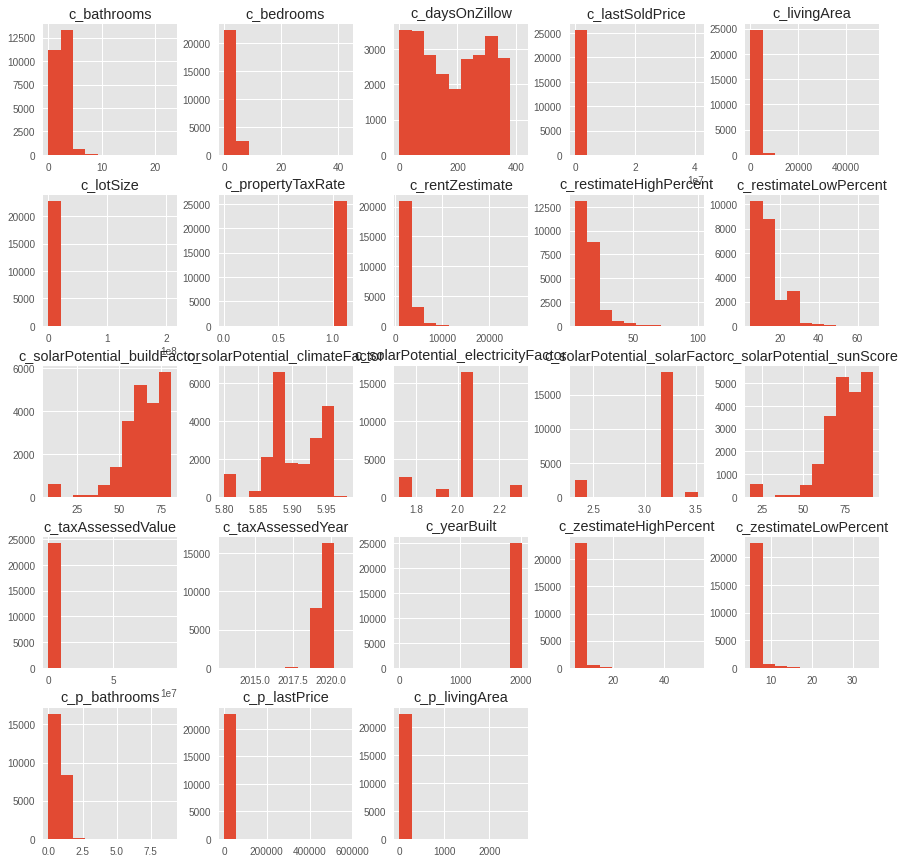

In [50]:
df[varc].hist(figsize=(15,15))

### Outliers

In [51]:
df.reset_index(drop=True, inplace = True)

In [52]:
X = df[um + varc].copy()
X = X.dropna()

In [53]:
#We will try now with LOF
outliers = LocalOutlierFactor(n_neighbors=5, metric="euclidean", contamination=0.1, n_jobs=-1)

y_pred = outliers.fit_predict(X[varc])
X["outlier"] = y_pred

In [54]:
X["outlier"].value_counts(True)

 1    0.899985
-1    0.100015
Name: outlier, dtype: float64

#### Deleting Outliers

In [55]:
df = df.merge(X[["zpid", "outlier"]], on=um, how = "inner")

In [56]:
df = df.loc[df["outlier"] == 1].reset_index(drop=True).drop(["outlier"], axis=1)

array([[<AxesSubplot:title={'center':'c_bathrooms'}>,
        <AxesSubplot:title={'center':'c_bedrooms'}>,
        <AxesSubplot:title={'center':'c_daysOnZillow'}>,
        <AxesSubplot:title={'center':'c_lastSoldPrice'}>,
        <AxesSubplot:title={'center':'c_livingArea'}>],
       [<AxesSubplot:title={'center':'c_lotSize'}>,
        <AxesSubplot:title={'center':'c_propertyTaxRate'}>,
        <AxesSubplot:title={'center':'c_rentZestimate'}>,
        <AxesSubplot:title={'center':'c_restimateHighPercent'}>,
        <AxesSubplot:title={'center':'c_restimateLowPercent'}>],
       [<AxesSubplot:title={'center':'c_solarPotential_buildFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_climateFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_electricityFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_solarFactor'}>,
        <AxesSubplot:title={'center':'c_solarPotential_sunScore'}>],
       [<AxesSubplot:title={'center':'c_taxAssessedValue'}>,


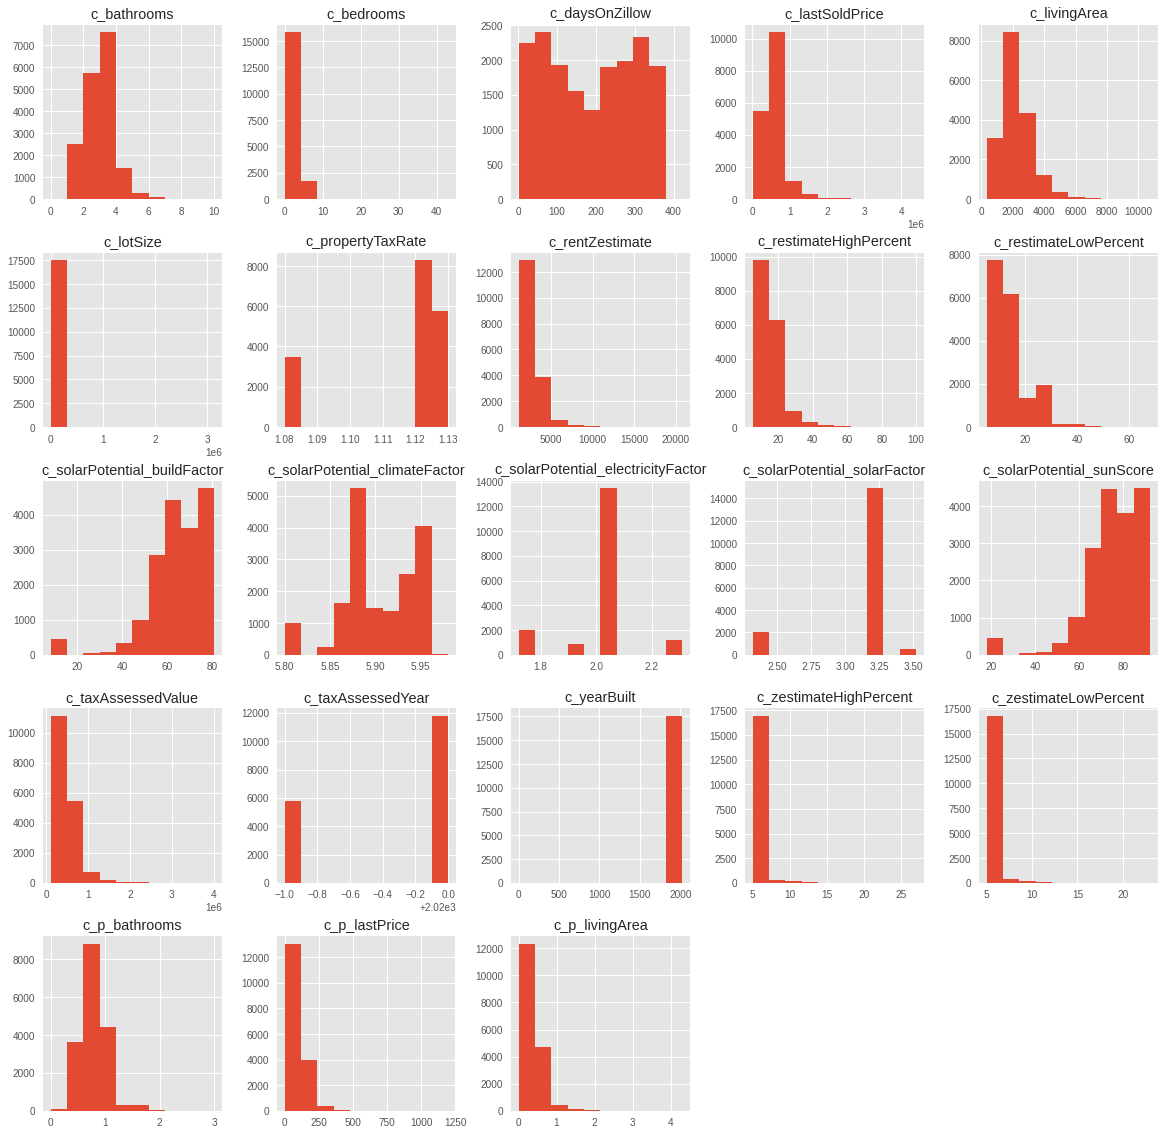

In [57]:
df[varc].hist(figsize=(20,20))

In [58]:
#We no longer have missing values
miss = 1 - df[varc].describe().T[['count']] / len(df[varc])
miss

count
c_bathrooms                           0.0
c_bedrooms                            0.0
c_daysOnZillow                        0.0
c_lastSoldPrice                       0.0
c_livingArea                          0.0
c_lotSize                             0.0
c_propertyTaxRate                     0.0
c_rentZestimate                       0.0
c_restimateHighPercent                0.0
c_restimateLowPercent                 0.0
c_solarPotential_buildFactor          0.0
c_solarPotential_climateFactor        0.0
c_solarPotential_electricityFactor    0.0
c_solarPotential_solarFactor          0.0
c_solarPotential_sunScore             0.0
c_taxAssessedValue                    0.0
c_taxAssessedYear                     0.0
c_yearBuilt                           0.0
c_zestimateHighPercent                0.0
c_zestimateLowPercent                 0.0
c_p_bathrooms                         0.0
c_p_lastPrice                         0.0
c_p_livingArea                        0.0

### Bivariate Analysis

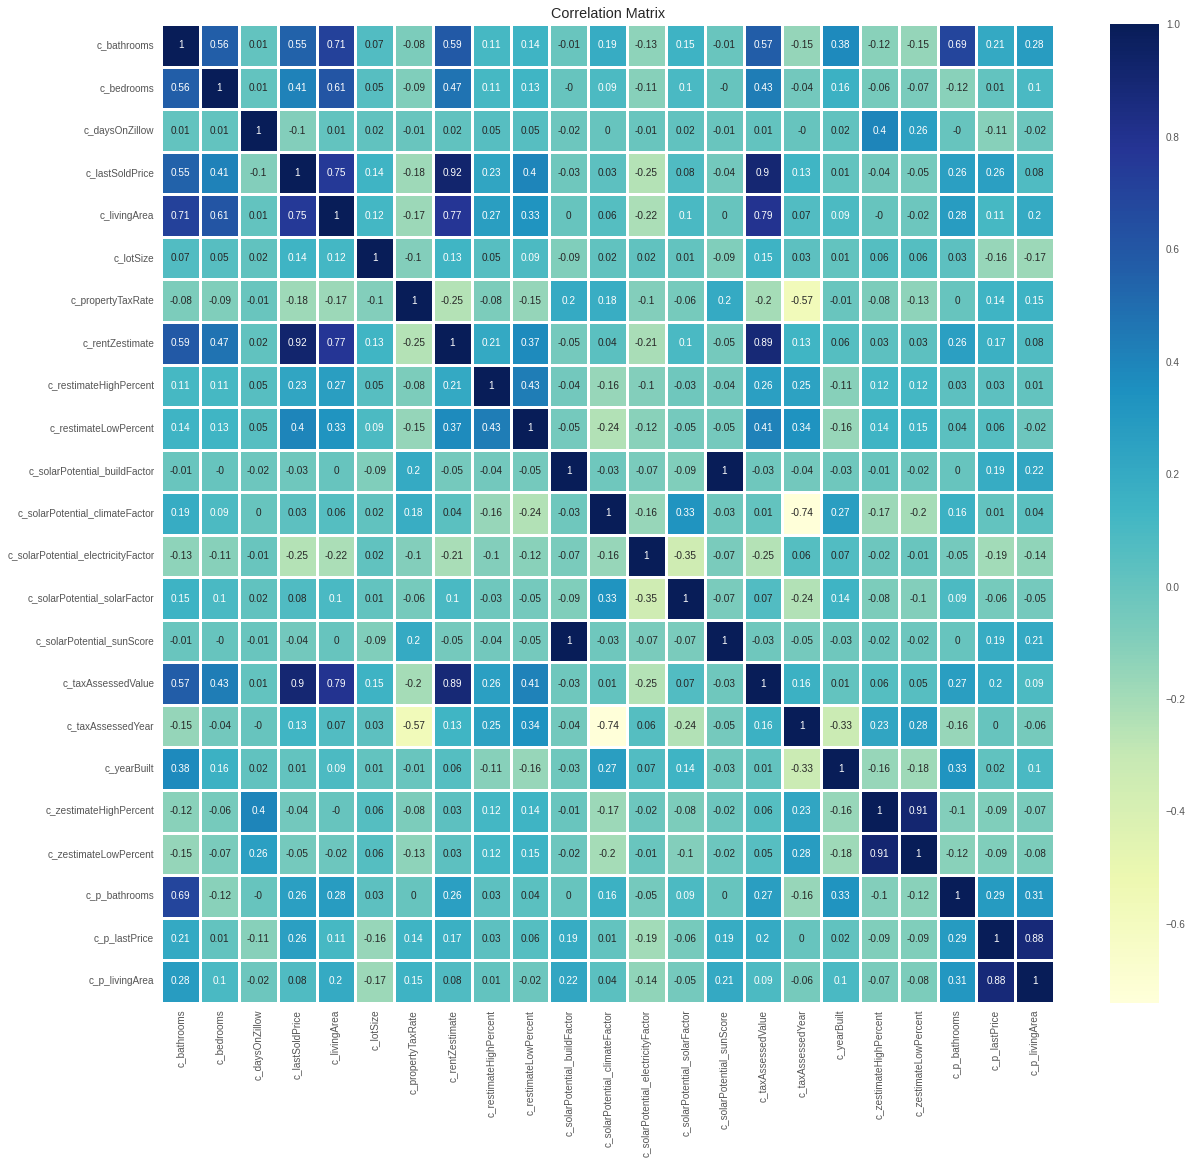

In [59]:
corr_df = df[varc].corr()
plt.figure(figsize=(20,18))
sns.heatmap(round(df[varc].corr(),2),annot=True, cmap='YlGnBu', linewidths=3, fmt='.2g')
plt.title('Correlation Matrix')
plt.show()

### Multicolinealidad

In [60]:
vc = VarClusHi(df=df[varc], feat_list = varc)
vc.varclus()

In [61]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio'] , ascending=[1,1]).reset_index(drop=True)

In [62]:
rs['id'] = rs.groupby('Cluster').cumcount()+1
rs

Cluster                            Variable    RS_Own     RS_NC  RS_Ratio  \
0         0                     c_rentZestimate  0.882475  0.215008  0.149715   
1         0                  c_taxAssessedValue  0.876411  0.205261  0.155509   
2         0                     c_lastSoldPrice  0.863820  0.192684  0.168683   
3         0                        c_livingArea  0.802067  0.286445  0.277390   
4         0                          c_bedrooms  0.385511  0.056698  0.651423   
5         0  c_solarPotential_electricityFactor  0.101292  0.027805  0.924412   
6         1      c_solarPotential_climateFactor  0.769487  0.057981  0.244701   
7         1                   c_taxAssessedYear  0.755468  0.319750  0.359474   
8         1        c_solarPotential_solarFactor  0.279689  0.016037  0.732050   
9         1                         c_yearBuilt  0.295258  0.147899  0.827063   
10        2           c_solarPotential_sunScore  0.999879  0.046244  0.000127   
11        2        c_solarPotential_buildFactor  0.999879  0.047225  0.000127   
12        3              c_zestimateHighPercent  0.933423  0.051707  0.070208   
13        3               c_zestimateLowPercent  0.858485  0.073599  0.152758   
14        3                      c_daysOnZillow  0.314711  0.004507  0.688392   
15        4                       c_p_lastPrice  0.913636  0.076603  0.093529   
16        4                      c_p_livingArea  0.914308  0.104767  0.095720   
17        4                           c_lotSize  0.111779  0.018120  0.904613   
18        5                       c_p_bathrooms  0.847100  0.086612  0.167399   
19        5                         c_bathrooms  0.847100  0.447450  0.276717   
20        6              c_restimateHighPercent  0.713933  0.064033  0.305637   
21        6               c_restimateLowPercent  0.713933  0.150709  0.336830   
22        7                   c_propertyTaxRate  1.000000  0.082998  0.000000   

    id  
0    1  
1    2  
2    3  
3    4  
4    5  
5    6  
6    1  
7    2  
8    3  
9    4  
10   1  
11   2  
12   1  
13   2  
14   3  
15   1  
16   2  
17   3  
18   1  
19   2  
20   1  
21   2  
22   1

# Variable Engineering

#We define our new DataFrame
df = df[um+varn+varc]
df.head()

df.shape

In [63]:
X = df[varc].copy()

## Dummies

In [64]:
df_cat = pd.get_dummies(df[varn])
df_cat

v_address_city_Beaverton  v_address_city_Gresham  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             0                       1   
4                             0                       1   
...                         ...                     ...   
17560                         0                       0   
17561                         0                       0   
17562                         0                       0   
17563                         1                       0   
17564                         0                       0   

       v_address_city_Happy Valley  v_address_city_Hillsboro  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                0                         0   
4                                0                         0   
...                            ...                       ...   
17560                            0                         0   
17561                            0                         0   
17562                            0                         0   
17563                            0                         0   
17564                            0                         0   

       v_address_city_Lake Oswego  v_address_city_Oregon City  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
17560                           0                           0   
17561                           0                           0   
17562                           0                           0   
17563                           0                           0   
17564                           1                           0   

       v_address_city_Portland  v_address_city_SMALL_CATEGORIES  \
0                            0                                1   
1                            0                                1   
2                            0                                1   
3                            0                                0   
4                            0                                0   
...                        ...                              ...   
17560                        1                                0   
17561                        1                                0   
17562                        0                                0   
17563                        0                                0   
17564                        0                                0   

       v_address_city_Tigard  v_address_zipcode_97007  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
...                      ...                      ...   
17560                      0                        0   
17561                      0                        0   
17562                      1                        0   
17563                      0                        1   
17564                      0                        0   

       v_address_zipcode_97045  v_address_zipcode_97080  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                     

## Scaling Values

### Standard Scaler

In [65]:
Sc = StandardScaler()

df_scaled = pd.DataFrame(Sc.fit_transform(X[varc]), columns=X.columns)
df_scaled.head()

c_bathrooms  c_bedrooms  c_daysOnZillow  c_lastSoldPrice  c_livingArea  \
0     0.500731   -0.460524       -1.436926        -0.884107     -0.402324   
1     0.500731   -0.460524       -1.392651        -1.001026     -0.719632   
2     1.567990    0.624389        0.139258        -0.475880      0.445197   
3    -0.566529   -0.460524       -0.923338        -0.875520     -0.801518   
4    -0.566529   -0.460524        0.670556        -1.152955     -0.390041   

   c_lotSize  c_propertyTaxRate  c_rentZestimate  c_restimateHighPercent  \
0  -0.229903           0.257887        -0.750322               -0.418969   
1  -0.224811           0.257887        -0.796068               -0.158356   
2  -0.165498           0.257887         0.476516                0.753789   
3  -0.167268           0.257887        -0.652175               -0.028049   
4  -0.224811           0.257887        -0.857618                0.623483   

   c_restimateLowPercent  c_solarPotential_buildFactor  \
0               0.440937                      0.293908   
1               0.157474                      0.646646   
2               0.724399                      0.293908   
3              -1.259840                      0.881804   
4               0.015743                      0.823015   

   c_solarPotential_climateFactor  c_solarPotential_electricityFactor  \
0                       -2.280651                            2.099820   
1                       -2.280651                            2.099820   
2                       -2.280651                            2.099820   
3                       -1.101240                            0.205756   
4                       -2.280651                            0.205756   

   c_solarPotential_solarFactor  c_solarPotential_sunScore  \
0                     -2.689065                   0.247787   
1                     -2.689065                   0.601389   
2                     -2.689065                   0.247787   
3                      1.250764                   0.910055   
4                      0.331470                   0.826811   

   c_taxAssessedValue  c_taxAssessedYear  c_yearBuilt  c_zestimateHighPercent  \
0           -0.887461           0.699782     0.911854               -0.617017   
1           -1.046096           0.699782     0.755832               -0.617017   
2           -0.438585           0.699782     0.755832                0.232149   
3           -0.915031           0.699782     0.079736               -0.617017   
4           -0.918211           0.699782     0.157747                0.232149   

   c_zestimateLowPercent  c_p_bathrooms  c_p_lastPrice  c_p_livingArea  
0              -0.469996       1.048706       1.696220        3.342535  
1              -0.469996       1.048706       1.027364        2.072969  
2              -0.469996       1.048706       0.252841        1.289141  
3              -0.469996      -0.331977      -0.215885        0.011219  
4               0.503987      -0.331977       0.607785        2.848410

### MinMax Scaler

In [66]:
mm = MinMaxScaler()
df_mm = pd.DataFrame(mm.fit_transform(X[varc]), columns=X.columns)

df_mm.head()

c_bathrooms  c_bedrooms  c_daysOnZillow  c_lastSoldPrice  c_livingArea  \
0          0.3    0.069767        0.057007         0.071621      0.142474   
1          0.3    0.069767        0.068884         0.063571      0.112752   
2          0.4    0.093023        0.479810         0.099727      0.221860   
3          0.2    0.069767        0.194774         0.072212      0.105081   
4          0.2    0.069767        0.622328         0.053111      0.143624   

   c_lotSize  c_propertyTaxRate  c_rentZestimate  c_restimateHighPercent  \
0   0.000496                0.8         0.044442                0.073684   
1   0.000555                0.8         0.041652                0.094737   
2   0.001250                0.8         0.119274                0.168421   
3   0.001229                0.8         0.050429                0.105263   
4   0.000555                0.8         0.037898                0.157895   

   c_restimateLowPercent  c_solarPotential_buildFactor  \
0               0.190476                      0.824176   
1               0.158730                      0.890110   
2               0.222222                      0.824176   
3               0.000000                      0.934066   
4               0.142857                      0.923077   

   c_solarPotential_climateFactor  c_solarPotential_electricityFactor  \
0                        0.055556                            1.000000   
1                        0.055556                            1.000000   
2                        0.055556                            1.000000   
3                        0.333333                            0.576271   
4                        0.055556                            0.576271   

   c_solarPotential_solarFactor  c_solarPotential_sunScore  \
0                      0.000000                   0.815747   
1                      0.000000                   0.880682   
2                      0.000000                   0.815747   
3                      1.000000                   0.937365   
4                      0.766667                   0.922078   

   c_taxAssessedValue  c_taxAssessedYear  c_yearBuilt  c_zestimateHighPercent  \
0            0.042363                1.0     0.993073                0.000000   
1            0.031873                1.0     0.990104                0.000000   
2            0.072045                1.0     0.990104                0.045455   
3            0.040539                1.0     0.977239                0.000000   
4            0.040329                1.0     0.978723                0.045455   

   c_zestimateLowPercent  c_p_bathrooms  c_p_lastPrice  c_p_livingArea  
0               0.000000       0.333333       0.169335        0.269880  
1               0.000000       0.333333       0.134191        0.199557  
2               0.000000       0.333333       0.093496        0.156140  
3               0.000000       0.222222       0.068868        0.085354  
4               0.055556       0.222222       0.112146        0.242510

# Dimensional Scaling

In [67]:
df_scaled.shape

(17565, 23)

## PCA

### Standard Scaler

Text(0, 0.5, 'Explained Variance')

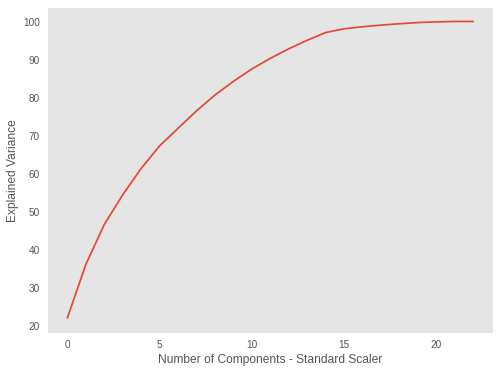

In [68]:
pca = PCA(n_components=23)
pca.fit(df_scaled)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components - Standard Scaler')
plt.ylabel('Explained Variance')

In [69]:
#We stay with 6 and 7 components
for n_comp in range(1,24):
    print(f"N componentes : {n_comp}")
    pca = PCA(n_components=n_comp)
    pca.fit(df_scaled)
    print(sum(pca.explained_variance_ratio_))
    print("\n")

N componentes : 1
0.2185563639224965


N componentes : 2
0.35945377664611444


N componentes : 3
0.46485357341657335


N componentes : 4
0.5431177604399738


N componentes : 5
0.6125864216533627


N componentes : 6
0.6720609058645542


N componentes : 7
0.7184266941577128


N componentes : 8
0.7642763064345843


N componentes : 9
0.8060856968193164


N componentes : 10
0.842136210719168


N componentes : 11
0.8748093927266368


N componentes : 12
0.9027638790096078


N componentes : 13
0.9278366262261296


N componentes : 14
0.9504219614384481


N componentes : 15
0.9707828915533716


N componentes : 16
0.9806587770699879


N componentes : 17
0.9859983204196746


N componentes : 18
0.990386280216262


N componentes : 19
0.9940157767358285


N componentes : 20
0.9970782901131434


N componentes : 21
0.9988781557139402


N componentes : 22
0.9999999978206536


N componentes : 23
1.0




### MinMax Scaler

Text(0, 0.5, 'Explained Variance')

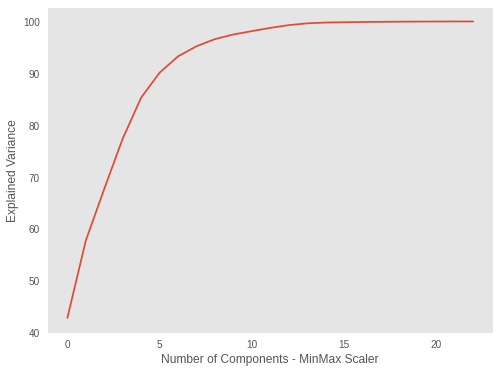

In [70]:
pca = PCA(n_components=23)
pca.fit(df_mm)

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components - MinMax Scaler')
plt.ylabel('Explained Variance')

In [71]:
#We stay with 3 components and the MinMaxScaler
for n_comp in range(1,23):
    print(f"N componentes : {n_comp}")
    pca = PCA(n_components=n_comp)
    pca.fit(df_mm)
    print(sum(pca.explained_variance_ratio_))
    print("\n")

N componentes : 1
0.42829444076945394


N componentes : 2
0.5776016054084785


N componentes : 3
0.6772217411663352


N componentes : 4
0.7741103180662336


N componentes : 5
0.8531527164122177


N componentes : 6
0.901219212216404


N componentes : 7
0.9327723937200001


N componentes : 8
0.9521899501396918


N componentes : 9
0.9660156839744631


N componentes : 10
0.9749029542332793


N componentes : 11
0.9813658124884077


N componentes : 12
0.9876201613937717


N componentes : 13
0.9929283759464597


N componentes : 14
0.9964071106503704


N componentes : 15
0.997911952036901


N componentes : 16
0.9985073269417668


N componentes : 17
0.998969454272176


N componentes : 18
0.999300629158173


N componentes : 19
0.9996022402885529


N componentes : 20
0.999777832733884


N componentes : 21
0.9999000237517421


N componentes : 22
0.9999999976489317




In [72]:
pca = PCA(n_components=6)
df_pca = pd.DataFrame(pca.fit_transform(df_mm))
df_pca.columns = [f"component_{x}" for x in range(6)]
print(sum(pca.explained_variance_ratio_[:6]))

0.9012192122164052


### Merging DF's

In [73]:
df_pca = pd.concat([df_pca, df_cat], axis=1)

# Clustering

## Number of Clusters

### Elbow

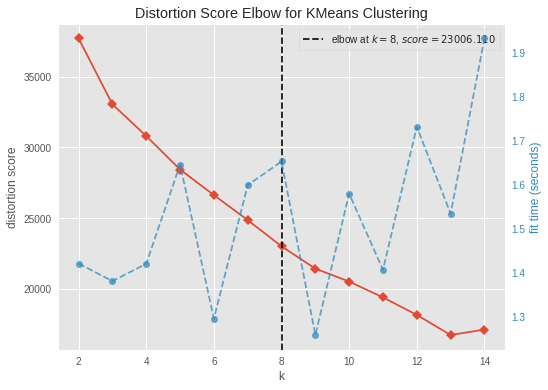

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
elbow(df_pca, 2, 15)

### Silhouette 

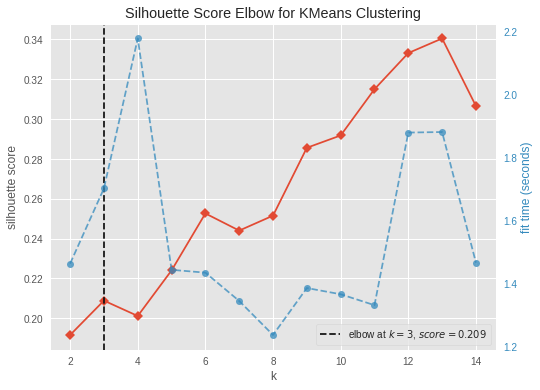

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [75]:
score_silhouette(df_pca, 2, 15)

### Calinski

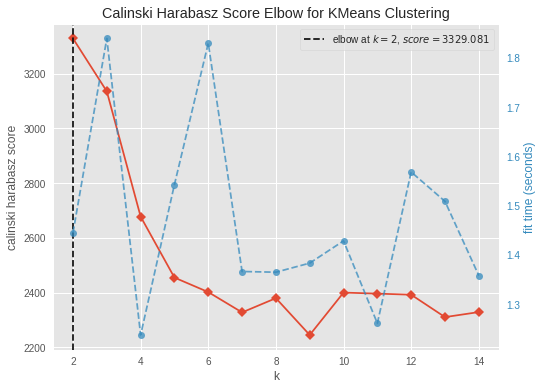

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [76]:
score_calinski(df_pca, 2, 15)

## Models

### PCA

In [77]:
KM_3 = KMeans(n_clusters = 3, n_init = 100, init='k-means++', random_state = 0).fit(df_pca)
KM_4 = KMeans(n_clusters = 4, n_init = 100, init='k-means++', random_state = 0).fit(df_pca)

### Labeling

In [78]:
df["Cluster_3_PCA"] = KM_3.labels_
df["Cluster_4_PCA"] = KM_4.labels_

## Visualizations

### 3 Clusters

In [93]:
### PCA
pca3 = PCA(n_components=2)

df_pca3 = pd.DataFrame(pca3.fit_transform(df_mm))
df_pca3.columns = ["P1", "P2"]
df_pca3["Labels"] = KM_3.labels_

fig = fig = px.scatter(df_pca3, x="P1", y="P2", color="Labels")
fig.show()

### 4 Clusters

In [80]:
#PCA
pca = PCA(n_components=2)

df_pca = pd.DataFrame(pca.fit_transform(df_mm))
df_pca.columns = ["P1", "P2"]
df_pca["Labels"] = KM_4.labels_

fig = fig = px.scatter(df_pca, x="P1", y="P2", color="Labels")
fig.show()

# Profiling

## 3 Clusters

In [81]:
df.drop(columns=["zpid","Cluster_4_PCA"]).groupby(["Cluster_3_PCA"]).mean().style.background_gradient() 

<AxesSubplot:xlabel='c_lastSoldPrice', ylabel='v_homeType'>

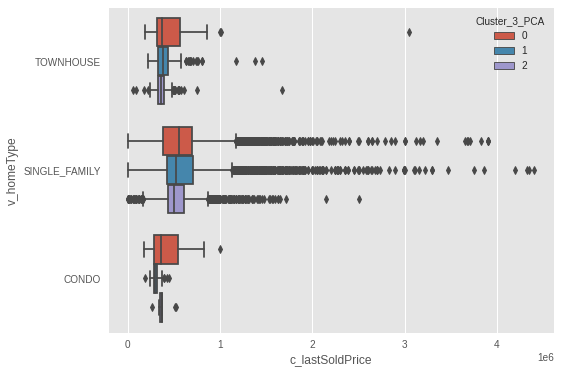

In [82]:
sns.boxplot(data=df , x = "c_lastSoldPrice", y = "v_homeType", hue="Cluster_3_PCA")

<AxesSubplot:xlabel='v_homeType', ylabel='count'>

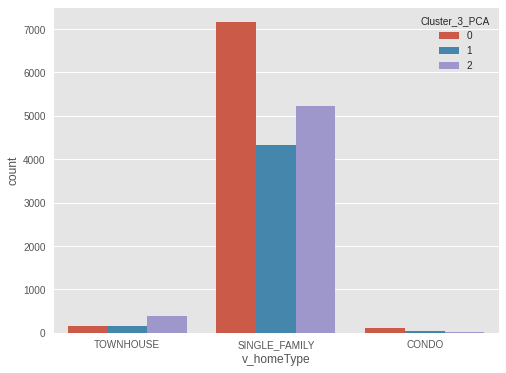

In [83]:
sns.countplot(data=df, x="v_homeType", hue="Cluster_3_PCA")

<AxesSubplot:xlabel='c_p_lastPrice', ylabel='v_homeType'>

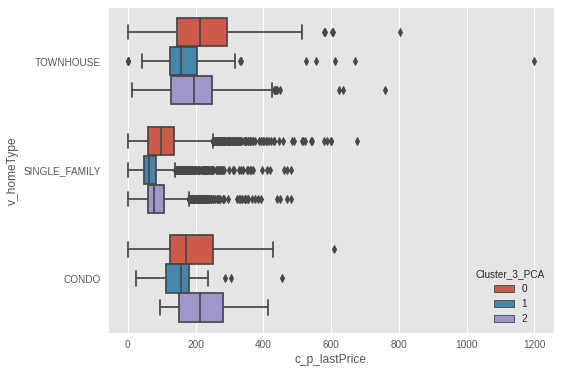

In [84]:
sns.boxplot(data=df , x = "c_p_lastPrice", y = "v_homeType", hue="Cluster_3_PCA")

<AxesSubplot:xlabel='v_brokerageName', ylabel='count'>

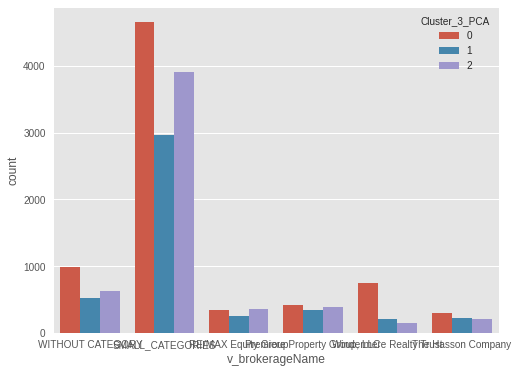

In [85]:
sns.countplot(data=df, x = "v_brokerageName", hue = "Cluster_3_PCA")

With 3 clusters using the PCA scaling, we have the following profiles:

- Cluster 0: Average House
- Cluster 1: Premium Houses
- Cluster 2: Entry Level Houses

**Average House**:
- Oldest houses, they were built in the 1950's
- These have the most expensive sqft with 109 USD
- They have the most potential for solar electricity

**Premium Houses**:
- Most expensive houses with an avg price of 625K USD.
- Most expensive rent with 3169 USD on avg (10% more than the next cluster) 
- They have the biggest lot size by 2x+

**Entry Level Houses**:
- Cheeapest houses, they have an avg sold price of 525K USD compared to 600K+ of th next cluster
- Newest houses, they were built in the 1990's while the nearest cluster was built in th 1980's
- The number of Bathrooms and Bedrooms tend to be the same

## 4 Clusters

In [86]:
df.drop(columns=["zpid","Cluster_3_PCA"]).groupby(["Cluster_4_PCA"]).mean().style.background_gradient() 

<AxesSubplot:xlabel='c_lastSoldPrice', ylabel='v_homeType'>

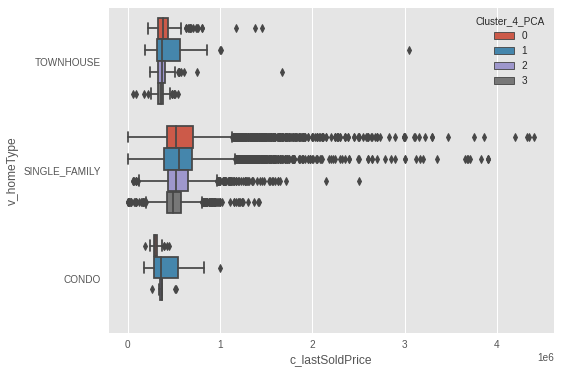

In [87]:
sns.boxplot(data=df , x = "c_lastSoldPrice", y = "v_homeType", hue="Cluster_4_PCA")

<AxesSubplot:xlabel='v_homeType', ylabel='count'>

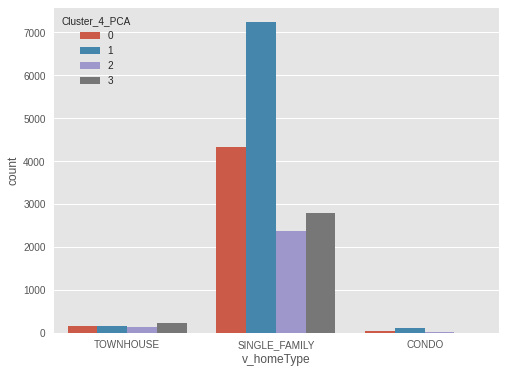

In [88]:
sns.countplot(data=df, x="v_homeType", hue="Cluster_4_PCA")

<AxesSubplot:xlabel='c_p_lastPrice', ylabel='v_homeType'>

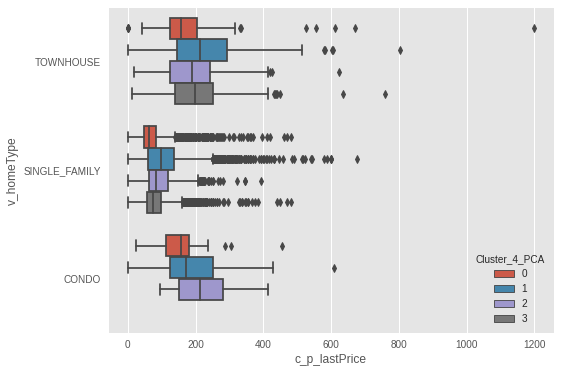

In [89]:
sns.boxplot(data=df , x = "c_p_lastPrice", y = "v_homeType", hue="Cluster_4_PCA")

<AxesSubplot:xlabel='v_brokerageName', ylabel='count'>

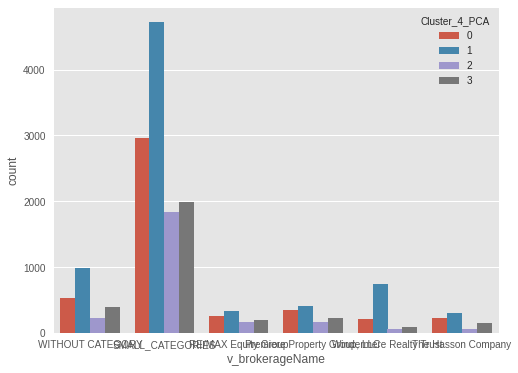

In [90]:
sns.countplot(data=df, x = "v_brokerageName", hue = "Cluster_4_PCA")

With 4 clusters using the PCA scaling, we have the following profiles:

- Cluster 0: Premium Houses
- Cluster 1: Gold Level Houses
- Cluster 2: Average Houses
- Cluster 3: Entry Level Houses

**Premium Houses**:
- Most expensive house on Zillow, avg sold price of 625K USD
- Most expensive rent with an avg price of 3169 USD
- They have the biggest lot size by almost 2x
- They are the least green-friendly houses
- Their property tax rate is the lowest

**Gold Level Houses**:
- Second most expensive houses with an avg price of 601K USD
- These are the oldest houses, they were built in the 1950's
- They have the most expensive sqft with 109 USD on avg
- They tend to have more bathrooms than bedrooms

**Average Houses**:
- They have the second largest lot size.
- They tend to have the same number of bathrooms and bedrooms
- These are the newest houses as they were built in the 1990's

**Entry Level Houses**:
- Cheapest houses with an avg price of 498K USD
- Cheapest rent with 2532 USD on avg
- They tend to have the same number of bathrooms and bedrooms
- Their property Tax Rates are the highest with 1.13

## Comparing to the previously made target (Premium houses)

In [91]:
aux = df.merge(prev, on="zpid", how="inner")
aux.head()

address_city  address_zipcode     brokerageName     homeStatus   homeType  \
0     Fairview            97024  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
1     Fairview            97024  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
2     Fairview            97024  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
3      Gresham            97080  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
4      Gresham            97030  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   

  rentalApplicationsAcceptedType      zpid    v_address_city  \
0               REQUEST_TO_APPLY  72258538  SMALL_CATEGORIES   
1               REQUEST_TO_APPLY  54008780  SMALL_CATEGORIES   
2               REQUEST_TO_APPLY  53863379  SMALL_CATEGORIES   
3               REQUEST_TO_APPLY  53825115           Gresham   
4               REQUEST_TO_APPLY  53831277           Gresham   

  v_address_zipcode   v_brokerageName   v_homeStatus v_homeType  \
0  SMALL_CATEGORIES  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
1  SMALL_CATEGORIES  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
2  SMALL_CATEGORIES  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
3             97080  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   
4  SMALL_CATEGORIES  WITHOUT CATEGORY  RECENTLY_SOLD  TOWNHOUSE   

  v_rentalApplicationsAcceptedType  c_bathrooms  c_bedrooms  c_daysOnZillow  \
0                 REQUEST_TO_APPLY          3.0         3.0            25.0   
1                 REQUEST_TO_APPLY          3.0         3.0            30.0   
2                 REQUEST_TO_APPLY          4.0         4.0           203.0   
3                 REQUEST_TO_APPLY          2.0         3.0            83.0   
4                 REQUEST_TO_APPLY          2.0         3.0           263.0   

   c_lastSoldPrice  c_livingArea  c_lotSize  c_propertyTaxRate  \
0           315400        1806.0     1555.0               1.12   
1           280000        1496.0     1742.0               1.12   
2           439000        2634.0     3920.0               1.12   
3           318000        1416.0     3855.0               1.12   
4           234000        1818.0     1742.0               1.12   

   c_rentZestimate  c_restimateHighPercent  c_restimateLowPercent  \
0           1950.0                    12.0                   17.0   
1           1895.0                    14.0                   15.0   
2           3425.0                    21.0                   19.0   
3           2068.0                    15.0                    5.0   
4           1821.0                    20.0                   14.0   

   c_solarPotential_buildFactor  c_solarPotential_climateFactor  \
0                          68.0                            5.81   
1                          72.8                            5.81   
2                          68.0                            5.81   
3                          76.0                            5.86   
4                          75.2                            5.81   

   c_solarPotential_electricityFactor  c_solarPotential_solarFactor  \
0                                2.31                          2.32   
1                                2.31                          2.32   
2                                2.31                          2.32   
3                                2.06                          3.52   
4                                2.06                          3.24   

   c_solarPotential_sunScore  c_taxAssessedValue  c_taxAssessedYear  \
0                      78.44            273960.0             2020.0   
1                      83.24            233050.0             2020.0   
2                      78.44            389720.0             2020.0   
3                      87.43            266850.0             2020.0   
4                      86.30            266030.0             2020.0   

   c_yearBuilt  c_zestimateHighPercent  c_zestimateLowPercent  c_p_bathrooms  \
0       2007.0                     5.0                    5.0       1.000000   
1       2001.0                     

In [94]:
aux[aux["Premium"] == "Yes"][["Cluster_3_PCA", "c_bedrooms","c_lastSoldPrice"]].groupby("Cluster_3_PCA").agg("mean")

c_bedrooms  c_lastSoldPrice
Cluster_3_PCA                             
0                5.203554    910731.153473
1                5.263158    912291.680581
2                5.135135    705512.337838

In [95]:
aux[aux["Premium"] == "Yes"][["Cluster_4_PCA", "c_bedrooms","c_lastSoldPrice"]].groupby("Cluster_4_PCA").agg("mean")

c_bedrooms  c_lastSoldPrice
Cluster_4_PCA                             
0                5.263158    912291.680581
1                5.204473    908250.134185
2                5.141869    746713.826990
3                5.121622    652401.328829